# Process exome data

Part one processes gene based exome data

Part two processes follow-up analysis of variant based exome data

## Gene-based exome data

In [1]:
import pandas as pd
import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#paths + settings
results_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results/"
in_path_sets = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie/exome/functional_annotation/selected_variants_v1"
run_name = "AICHA_rs_conn"
set_size=200 #DON'T CHANGE, was used to run regenie in smaller sets on RAP
save_lists=False

alpha_suggestive = -np.log10(0.05/18882)    
alpha_burden_genebass = -np.log10(6.7 * 10 ** -7)
alpha_skato_genebass = -np.log10(2.5 * 10 ** -7) #from genebass paper: https://www.cell.com/cell-genomics/fulltext/S2666-979X(22)00110-0#secsectitle0080
      

In [3]:
#! pyensembl install --release 108 --species homo_sapiens

In [3]:
def split_sets(in_path, file_name_ext, run_name, set_size, chr_no, save_lists=True):
    """
    Subdivides all genes for one chromosome into smaller sets in order to improve parallellization
    """
    
    #load data
    all_sets = pd.read_csv(os.path.join(in_path, file_name_ext), sep="\t", names="Gene CHR POS VARS".split())
    
    #get number of sets
    no_sets = ( len(all_sets) // set_size ) + 1

    if save_lists:
        for i in range( no_sets ):      
            #get set 
            this_set = list(all_sets.Gene[ (i*set_size):((i+1)*set_size)])
            print(this_set[0])

            #save set
            with open(os.path.join(in_path, "{0}_c{1}_extract_set_{2}.txt".format(run_name, chr_no, i, no_sets)), 'w') as file:
                for row in this_set:
                    s = "".join(map(str, row))
                    file.write(s+'\n')

    return chr_no, no_sets

df_all_sets = pd.DataFrame(columns="Chr_no No_sets".split())

for c in range(1, 23, 1):
    df_all_sets.loc[len(df_all_sets)] = split_sets(in_path = in_path_sets,
                                                       file_name_ext = "{0}_c{1}_set_list.txt".format(run_name, c) ,
                                                       run_name = run_name,
                                                       set_size = set_size,
                                                       chr_no = c,
                                                       save_lists=save_lists)
c="X"
df_all_sets.loc[len(df_all_sets)] = split_sets(in_path = in_path_sets,
                                                       file_name_ext = "{0}_c{1}_set_list.txt".format(run_name, c) ,
                                                       run_name = run_name,
                                                       set_size = set_size,
                                                       chr_no = c,
                                                       save_lists=save_lists)

In [4]:
## FUNCTIONS

## DATA LOADING FUNCTIONS
# (1) read file
# (2) add together all phenos per set as extra columns
# (3) add all sets per chromosome
# (4) add all chromosomes

def read_sumstats_REGENIE(fn):
    """
    Reads sumstats
    
    Converts regenie output to MRP format (PLINK-like)
    - add necessary column
    - change column names
    
    """
    data = pd.read_csv(fn, sep=" ", skiprows=1)
    
    #get phenotype name
    pheno_in = re.search("sent_edges_*.*", fn)
    pheno = pheno_in.group()[:-11]
    
    data["TEST_ID"] = data["ID"] + "." + data["TEST"]
    
    #rename
    data.rename(columns = {"LOG10P": "LOGP_{0}".format(pheno),
                           "BETA":"BETA_{0}".format(pheno),
                           "CHISQ":"CHISQ_{0}".format(pheno),
                           "SE":"SE_{0}".format(pheno)},
                inplace=True)
    
    return data.set_index("TEST_ID")
    #return data

def data_loader_REGENIE_set(regenie_path, search_term):
    """
    loads data for all phenotypes of one set
    """
    #get file list
    file_list = sorted(glob.glob(os.path.join(regenie_path, search_term)))
    
    print(search_term + " --> number of files: " + str(len(file_list)))
          
    if len(file_list) > 0:
        #load data (cleaning up in helper functions)
        return pd.concat(map(read_sumstats_REGENIE, file_list), join="inner", axis=1)
    
    else:
        return pd.DataFrame()
    
def data_loader_REGENIE_chromosome(regenie_path, search_term, no_sets):
    """
    loads data for all sets and phenotype of a particular chromosome
    """
    return pd.concat(map(data_loader_REGENIE_set, [regenie_path]*no_sets, [search_term.format(i) for i in range(no_sets)]), axis=0)

def data_loader_REGENIE_all_chromosomes(regenie_path, search_term, no_sets, chr_nos):
    """
    """
    regenie_paths=[regenie_path.format(chr_no) for chr_no in chr_nos]
    search_terms=[search_term.format(chr_no, "{}") for chr_no in chr_nos]
    
    return pd.concat(map(data_loader_REGENIE_chromosome, regenie_paths, search_terms, no_sets))


## HELPERS ##


def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ]

def get_gene_name(gene_id, data_ens):
    """
    """
    try:
        gene_name = data_ens.gene_name_of_gene_id(gene_id)
    except ValueError:
        gene_name = ""
    return gene_name

def add_gene_names(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_id"] = [id_name.split(".")[0] for id_name in data["ID"]]
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["gene_id"]]
    
    return data

def get_min_P_REGENIE(data, pheno_list=None):
    """
    Finds highest -logp value per variant
    
    Returns data with MIN_LOGP column added.
    
    """
    #filter
    if pheno_list is None:
        r=re.compile("LOGP_*.")
        pheno_list = list(filter(r.match, data.columns))
    
    #find highest
    return data[pheno_list].T.max()

## ALL DATA MUNGING
    
def data_munging_all(regenie_path, search_term, no_sets, chr_nos, fn_pheno_edges, fn_pheno_HDs):
    """
    """
    
    data = data_loader_REGENIE_all_chromosomes(regenie_path, search_term, no_sets, chr_nos)
    
    data = data.T.drop_duplicates().T
    
    phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
    phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
    
    data["MINP_edges"] = get_min_P_REGENIE(data, phenos_edges)
    data["MINP_HDs"] = get_min_P_REGENIE(data, phenos_HDs)
    
    data = add_gene_names(data)
    
    return data

def get_cumulative_pos(df):
    """
    Adds cumulative position to dataframe for plotting purposes
    """
    running_pos = 0

    cumulative_pos = []

    for chrom, group_df in df.groupby('CHROM'):  
        cumulative_pos.append(group_df['GENPOS'] + running_pos)
        running_pos += group_df['GENPOS'].max()

    df['cumulative_pos'] = pd.concat(cumulative_pos)
    
    return df

def miami_exome_regenie(df1, df2, y_name1, y_name2, y_dsc1, y_dsc2, title_str, alpha, figargs= {"figsize":(14,10),"dpi":150}):
    """
    Big plotting function to make a gene-based Miami plot
    """
    
    no_genes = len(df1)
    
    df1 = get_cumulative_pos(df1)
    df2 = get_cumulative_pos(df2)
    
    max_p1 = np.max(df1[y_name1])
    max_p2 = np.max(df2[y_name2])
    
    max_p = np.max([max_p1, max_p2]) 
    
    fig, (ax1, ax2) = plt.subplots(2, 1, 
        gridspec_kw={'height_ratios': [1, 1]},**figargs)
    plt.subplots_adjust(hspace=0.16)
    
    g = sns.scatterplot(data=df1,
                        #x=df1.index.values,
                        x="cumulative_pos",
                        y=y_name1,
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax1,
                        edgecolor="black")     

    g = sns.scatterplot(data=df2,
                        #x=df2.index.values,
                        x="cumulative_pos",
                        y=y_name2,
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax2,
                        edgecolor="black") 
    
    ax1.set_xticks(df1.groupby('CHROM')['cumulative_pos'].median())
    ax1.set_xticklabels(df1['CHROM'].unique())
    ax1.set_xlabel('Chromosome')
    ax1.set_ylabel(y_dsc1)
    ax1.set_ylim([0, max_p])

    if alpha is not None:
        ax1.plot([np.min(df1["cumulative_pos"]), np.max(df1["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
    
    ax2.set_xticks(df2.groupby('CHROM')['cumulative_pos'].median())
    ax2.set_ylim([0, max_p])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    
    ax2.xaxis.set_ticks_position("top")
    ax2.set_ylabel(y_dsc2)
    
    if alpha is not None:
        ax2.plot([np.min(df2["cumulative_pos"]), np.max(df2["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
   
    ax2.invert_yaxis()
    
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(True)
    ax1.spines["bottom"].set_visible(True)
    
    ax2.spines["top"].set_visible(True)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(True)
    ax2.spines["bottom"].set_visible(False)
    
    if alpha is not None:
        for gene in df1[df1[y_name1] > alpha].index.values:
            ax1.text(df1.loc[gene, "cumulative_pos"]+1, df1.loc[gene, y_name1]+0.25, df1.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
        for gene in df2[df2[y_name2] > alpha].index.values:
            ax2.text(df2.loc[gene, "cumulative_pos"]+1, df2.loc[gene, y_name2]+0.25, df2.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
    
    fig.suptitle(title_str)



In [6]:
data = data_munging_all(regenie_path="/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/c{}",
                        search_term="AICHA_rs_conn_gene_based_additive_sum_c{0}_set_{1}_sent_edges_*.regenie.gz",
                        no_sets=list(df_all_sets.No_sets),
                        chr_nos=list(df_all_sets.Chr_no),
                        fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
                        fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
data.to_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"))

In [5]:
data = pd.read_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"), engine="pyarrow")

In [6]:
data = add_gene_names(data)

# Plotting of exome results

/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:176: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_57255/687663859.py:190: UserWarning: The palette list has more

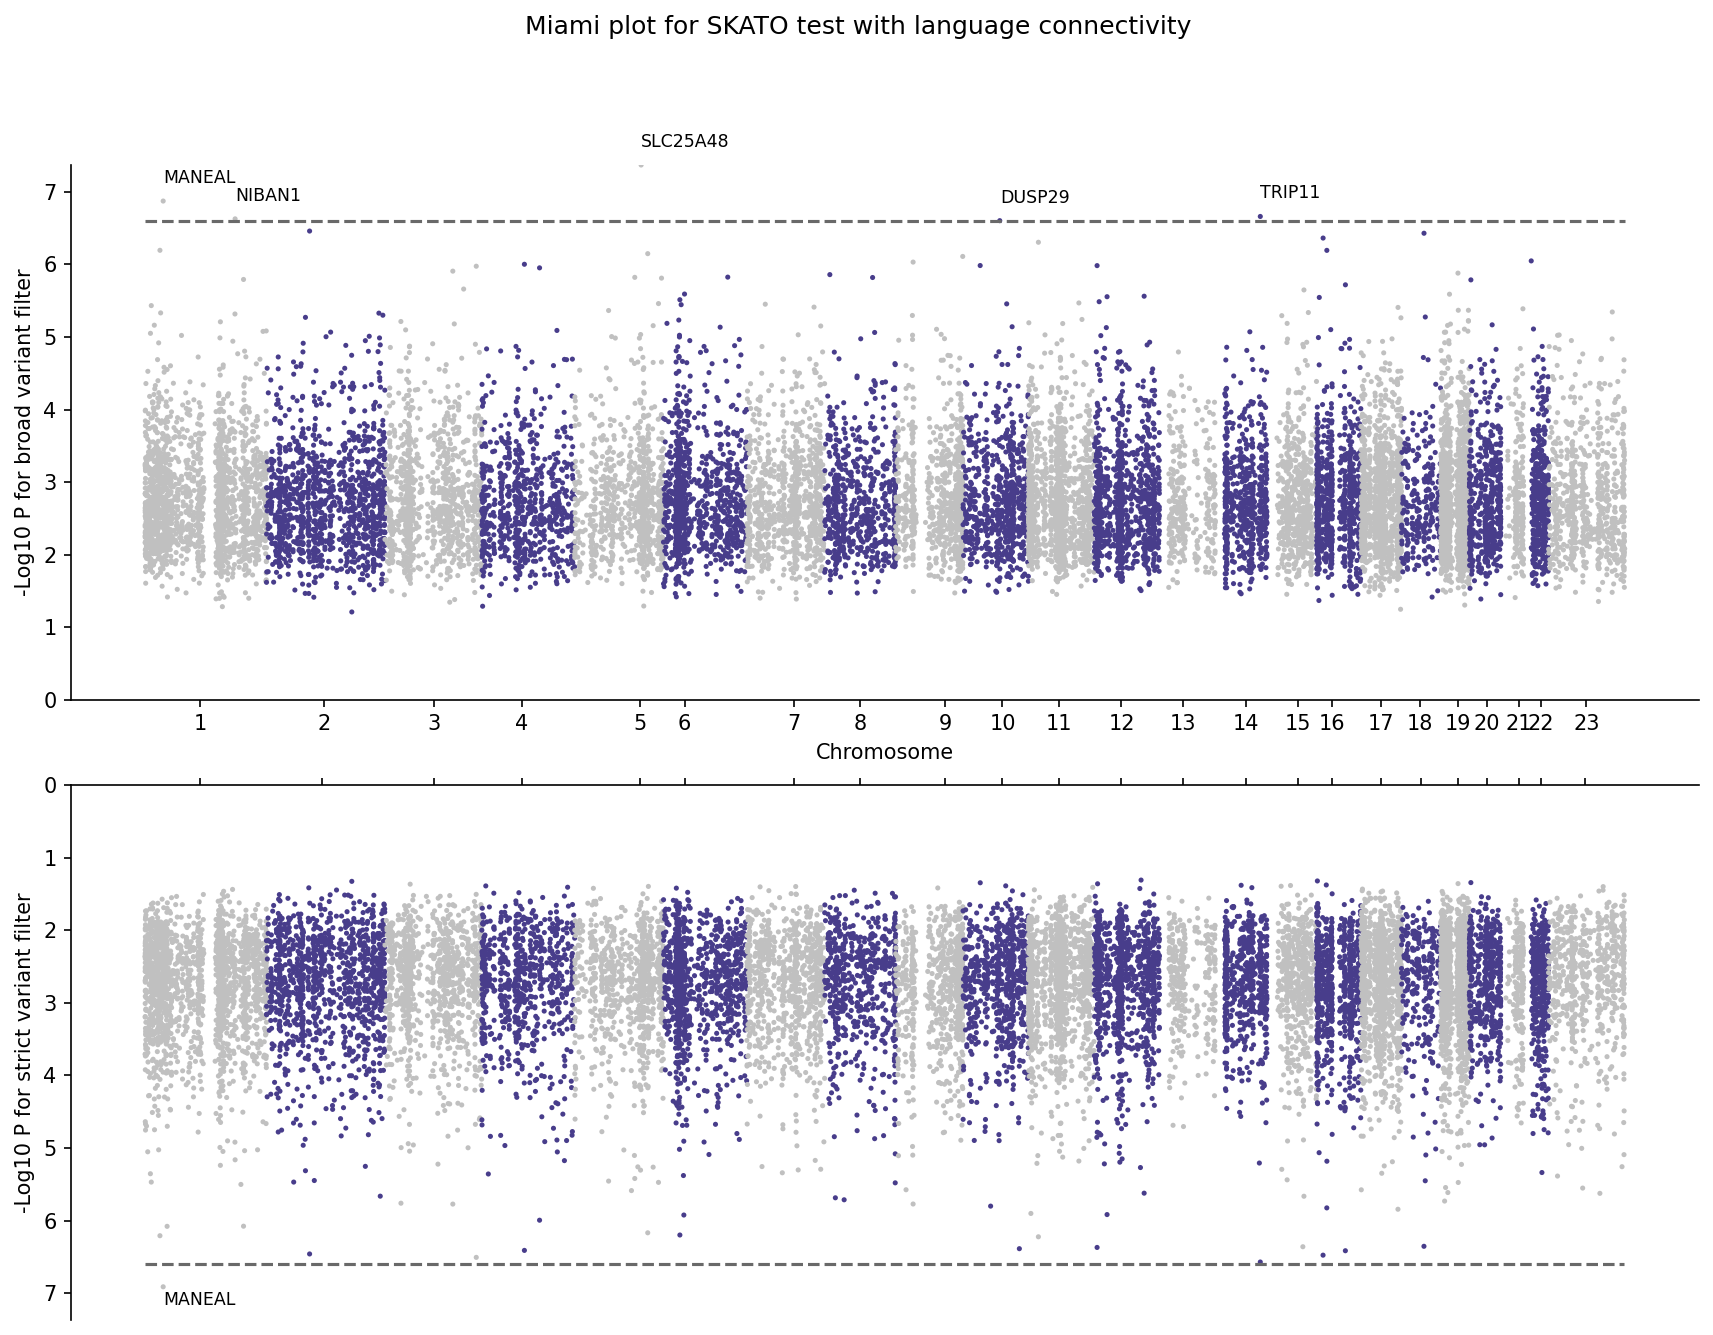

In [28]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]
miami_exome_regenie(df1 = data_skato_broad,
                    df2 = data_skato_strict,
                    y_name1 = "MINP_edges",
                    y_name2 = "MINP_edges",
                    alpha = alpha_skato_genebass,
                    y_dsc1 = "-Log10 P for broad variant filter",
                    y_dsc2 = "-Log10 P for strict variant filter",
                    title_str = "Miami plot for SKATO test with language connectivity")
plt.savefig(os.path.join(results_path, "Figs", "SKATO_lang_conn.png"))
plt.savefig(os.path.join(results_path, "Figs", "SKATO_lang_conn.svg"))

/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_57255/687663859.py:176: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_57255/687663859.py:190: UserWarning: The palette list has more

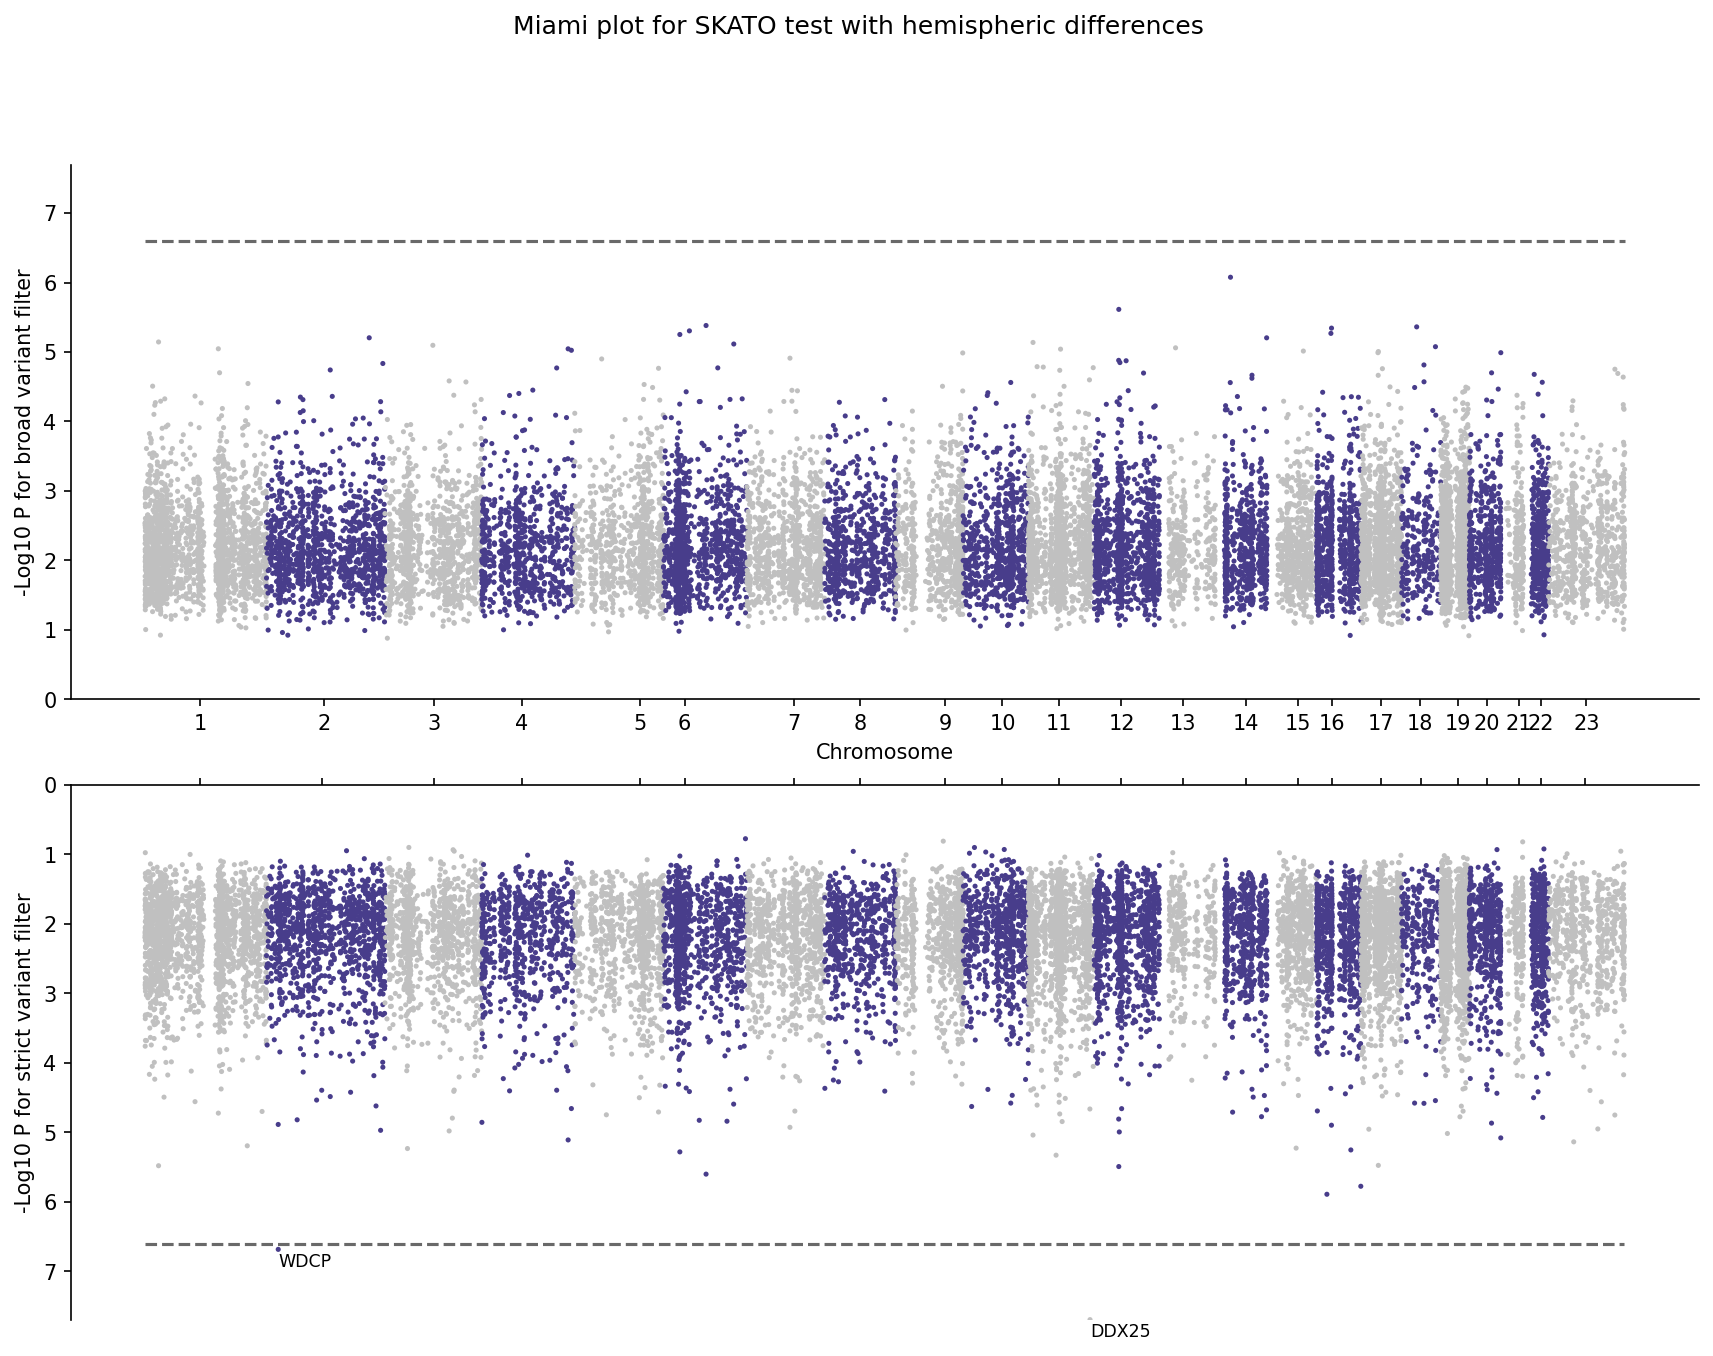

In [29]:
miami_exome_regenie(df1 = data_skato_broad,
                    df2 = data_skato_strict,
                    y_name1 = "MINP_HDs",
                    y_name2 = "MINP_HDs",
                    alpha = alpha_skato_genebass,
                    y_dsc1 = "-Log10 P for broad variant filter",
                    y_dsc2 = "-Log10 P for strict variant filter",
                    title_str = "Miami plot for SKATO test with hemispheric differences")
plt.savefig(os.path.join(results_path, "Figs", "SKATO_HDs.png"))
plt.savefig(os.path.join(results_path, "Figs", "SKATO_HDs.svg"))

In [ ]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]

make_all_ps_figure(data_broad = data_skato_broad,
                   data_strict = data_skato_strict,
                   fn_pheno_edges = "/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
                   fn_pheno_HDs = "/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt",
                   alpha=alpha_skato_genebass)

plt.savefig(os.path.join(results_path, "Figs", "QQs_p_distribution2.png"))

# Variant based exome data

## Get variants in significant genes

In [7]:
def data_loader_snpeff_file(fn):
    return pd.read_csv(fn, sep="\t", engine="pyarrow")

def data_loader_snpeff_all(search_term):
    """
    Loads snpeff output
    """
    file_list = sorted(glob.glob(search_term))
    
    return pd.concat(map(data_loader_snpeff_file, file_list), axis=0)
  
def get_variants_all(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = "CHROM POS ID REF ALT dbNSFP_Ensembl_geneid dbNSFP_Ensembl_transcriptid dbNSFP_CADD_phred".split())
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/exome_bim/dbnsfp_cadd/c{}/ukb23157_c*_b*_v1_site_only.snpeff.dbnsfp.cadd.singleline.tab".format(c)
        snpeff = data_loader_snpeff_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["dbNSFP_Ensembl_geneid"] == gene_id]])
    
    return out_df

def add_gene_names_snpeff(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["dbNSFP_Ensembl_geneid"]]
    
    del data_ens
    
    return data

def read_bim(fn):
    return pd.read_csv(fn, header=None, sep="\t", engine="pyarrow", names="CHROM ID N POS REF ALT".split())
    
def read_entire_bim(search_term, chr_nos):
    
    #file_list = sorted(glob.glob(search_term))
    file_list = sorted([search_term.format(chr_no) for chr_no in chr_nos])
    
    return pd.concat(map(read_bim, file_list), axis=0)
    


In [8]:
data_skato_strict = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(data), 1))]
data_skato_broad = data[np.array([data["TEST"] == "ADD-SKATO", data["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(data), 1))]

strict_sig = data_skato_strict[np.array([data_skato_strict["MINP_edges"] > alpha_skato_genebass, data_skato_strict["MINP_HDs"] > alpha_skato_genebass]).any(0).reshape((len(data_skato_strict), 1))]
broad_sig = data_skato_broad[np.array([data_skato_broad["MINP_edges"] > alpha_skato_genebass, data_skato_broad["MINP_HDs"] > alpha_skato_genebass]).any(0).reshape((len(data_skato_broad), 1))]
broad_variants = get_variants_all(broad_sig)
strict_variants = get_variants_all(strict_sig)

all_variants = pd.concat([broad_variants, strict_variants]).T.drop_duplicates().T
all_variants = add_gene_names_snpeff(all_variants)
all_variants["CHROM POS ID REF ALT dbNSFP_Ensembl_geneid dbNSFP_CADD_phred gene_name".split()].to_csv(os.path.join(results_path, "significant_vars.txt"), sep=" ", index=False)
all_variants["ID"].to_csv(os.path.join(results_path, "significant_vars_ids.txt"), sep=" ", index=False)

Chromosome 1
Gene ENSG00000135842
Gene ENSG00000185090
Chromosome 5
Gene ENSG00000145832
Chromosome 10
Gene ENSG00000188716
Chromosome 14
Gene ENSG00000100815
Chromosome 1
Gene ENSG00000185090
Chromosome 2
Gene ENSG00000163026
Chromosome 11
Gene ENSG00000109832


## Parse and combine variant-based exome results

In [60]:
#download data
#read in data together
def get_V(df):
    """
    Inserts variant column in MRP-like fashion
    """
    df.insert(
        loc=0,
        column="V",
        value=df["CHR"]
        .astype(str)
        .str.cat(df["POS"].astype(str), sep=":")
        .str.cat(df["REF"], sep=":")
        .str.cat(df["ALT"], sep=":"),
    )
    return df

def read_sumstats_REGENIE_vars(fn):
    """
    Reads sumstats and converts to ref alt
    
    Converts regenie output to MRP format (PLINK-like)
    - add necessary column
    - change column names
    
    """
    data = pd.read_csv(fn, index_col=None, sep=" ", engine="pyarrow")
    
    #add extra column necessary
    data["A1"] = data["ALLELE0"]
    
    #rename
    data["P"] = np.power(10, -data['LOG10P'])
    
    #get phenotype name
    pheno_in = re.search("sent_edges_*.*", fn)
    pheno = pheno_in.group()[:-11]
    
    #rename
    data.rename(columns = {'CHROM': 'CHR',
                           'GENPOS':'POS',
                           "LOG10P": "LOGP_{0}".format(pheno),
                           "P": "P_{0}".format(pheno),
                           "BETA":"BETA_{0}".format(pheno),
                           "SE":"SE_{0}".format(pheno)
                           }, inplace=True)
    
    #data = get_V(data)
    
    return data.set_index("ID")

def data_loader_REGENIE_vars(regenie_path, search_term, gene):
    """
    """
    #get file list
    file_list = sorted(glob.glob(os.path.join(regenie_path, search_term)))
    
    #load data (cleaning up in helper functions)
    return pd.concat(map(read_sumstats_REGENIE_vars, file_list), join="inner", axis=1)
    #data_vars["gene"] = [gene]*len(data_vars)
    #return data_vars

def data_loader_REGENIE_all_vars(regenie_path, search_term, genes):
    """
    """
    regenie_paths=[regenie_path.format(gene) for gene in genes]
    search_terms=[search_term.format(gene) for gene in genes]
    
    return pd.concat(map(data_loader_REGENIE_vars, regenie_paths, search_terms, genes))


def munge_data_all(regenie_path, search_term, genes, fn_pheno_edges, fn_pheno_HDs, alpha=np.log10(0.05/(1174*732))):
    #load data
    data = data_loader_REGENIE_all_vars(regenie_path, search_term, genes)
    
    #data = data.T.drop_duplicates().T
    
    return data

In [175]:
var_data = munge_data_all(regenie_path="/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/output_sig_variants/v2/{}",
                                            search_term="sent_all_st2_gene_vars_{}_sent_edges_*.regenie.gz",
                            genes="DDX25 WDCP DUSP29 MANEAL NIBAN1 SLC25A48 TRIP11".split(),
                        fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt",
                        fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
var_data = var_data.T.drop_duplicates().T

In [178]:
def get_variants_all_snpeff(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = "CHROM	POS	ID	REF	ALT	ALLELE	EFFECT	IMPACT	GENE	GENEID	FEATURE	FEATUREID	BIOTYPE	RANK	HGVS_C	HGVS_P	CDNA_POS	CDNA_LEN	CDS_POS	CDS_LEN	AA_POS	AA_LEN	DISTANCE	ERRORS".split("\t"))
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.tab".format(c)
        snpeff = data_loader_snpeff_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["GENEID"] == gene_id]])
    
    return out_df

def get_variants_unfiltered_snpeff(chroms):
    search_terms = ["/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.tab".format(c) for c in chroms]
    return pd.concat(map(data_loader_snpeff_all, search_terms))

def data_loader_CADD_file(fn):
    return pd.read_csv(fn, usecols=[0, 1, 2, 3, 4, 34, 60, 62], sep="\t",low_memory=False)

def data_loader_CADD_all(search_term):
    """
    Loads snpeff output
    """
    file_list = sorted(glob.glob(search_term))
    
    return pd.concat(map(data_loader_CADD_file, file_list), axis=0)

def get_variants_unfiltered_CADD(chroms):
    search_terms = ["/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.dbnsfp.tab".format(c) for c in chroms]
    return pd.concat(map(data_loader_CADD_all, search_terms))

def get_variants_all_CADD(genes_df):
    
    chroms = genes_df.CHROM.unique()
    
    out_df = pd.DataFrame(columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'dbNSFP_CADD_phred', 'dbNSFP_Ensembl_geneid', 'dbNSFP_Ensembl_transcriptid'])
    
    for c in chroms:
        print("Chromosome {}".format(c))
        search_term_snpeff = "/data/workspaces/lag/workspaces/lg-ukbiobank/derived_data/genetic_data/exome/exome_release_final/functional_annotation/annotated_variants/c{0}/ukb23157_c{0}_b*_v1_site_only.snpeff.dbnsfp.tab".format(c)
        snpeff = data_loader_CADD_all(search_term_snpeff)
        
        for gene_id in genes_df[genes_df.CHROM == c].gene_id:
            print("Gene {}".format(gene_id))
            out_df = pd.concat([out_df, snpeff[snpeff["dbNSFP_Ensembl_geneid"] == gene_id]])
    
    return out_df


In [179]:
snpeff_all = get_variants_unfiltered_snpeff(chroms=[1, 2, 5, 10, 11, 14])
cadd_all = get_variants_unfiltered_CADD(chroms=[1, 2, 5, 10, 11, 14])
all_annots = snpeff_all.merge(cadd_unfiltered, on="ID", how="left")

In [180]:
alpha = -np.log10(0.05/(860*732))

fn_pheno_edges="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt"
fn_pheno_HDs="/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt"

p_phenos_edges = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
p_phenos_HDs = ["LOGP_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
beta_phenos_edges = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
beta_phenos_HDs = ["BETA_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]
se_phenos_edges = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_edges)]
se_phenos_HDs = ["SE_sent_edges_"+x for x in load_column_names(fn_pheno_HDs)]

#get lowest P per value
var_data["MINP_edges"] = get_min_P_REGENIE(var_data, p_phenos_edges)
var_data["MINP_HDs"] = get_min_P_REGENIE(var_data, p_phenos_HDs)
var_data["MAC"] = np.multiply(np.multiply(var_data["A1FREQ"], var_data["N"]),2)

#get all P
edge_ps = var_data[p_phenos_edges]
hd_ps = var_data[p_phenos_HDs]
    
edge_betas = var_data[beta_phenos_edges]
hd_betas = var_data[beta_phenos_HDs]

var_data["edges_mean_beta"] = np.mean(edge_betas, axis=1)
var_data["HDs_mean_beta"] = np.mean(hd_betas, axis=1)
    
edge_ses = var_data[se_phenos_edges]
hd_ses = var_data[se_phenos_HDs]

In [198]:
canonical_trans = ["ENST00000373045.11", "ENST00000263576.11", "ENST00000367511.4", "ENST00000338487.6", "ENST00000267622.8", "ENST00000295148.9", "ENST00000681962.1"]
all_annots["canonical"] = all_annots["FEATUREID"].isin(canonical_trans)
all_annots.head()

,CHROM_x,POS_x,ID,REF_x,ALT_x,ALLELE,EFFECT,IMPACT,GENE,GENEID,...,DISTANCE,ERRORS,CHROM_y,POS_y,REF_y,ALT_y,dbNSFP_CADD_phred,dbNSFP_Ensembl_geneid,dbNSFP_Ensembl_transcriptid,canonical
0,chr1,69026,chr1_69026_T_G,T,G,G,downstream_gene_variant,MODIFIER,OR4G11P,ENSG00000240361,...,4910,,chr1,69026,T,G,0.0,.,.,False
1,chr1,69026,chr1_69026_T_G,T,G,G,intron_variant,MODIFIER,OR4F5,ENSG00000186092,...,0,,chr1,69026,T,G,0.0,.,.,False
2,chr1,69081,chr1_69081_G_C,G,C,C,synonymous_variant,LOW,OR4F5,ENSG00000186092,...,0,,chr1,69081,G,C,0.0,.,.,False
3,chr1,69081,chr1_69081_G_C,G,C,C,downstream_gene_variant,MODIFIER,OR4G11P,ENSG00000240361,...,4965,,chr1,69081,G,C,0.0,.,.,False
4,chr1,69095,chr1_69095_T_G,T,G,G,missense_variant,MODERATE,OR4F5,ENSG00000186092,...,0,,chr1,69095,T,G,21.6,"ENSG00000186092,ENSG00000186092","ENST00000641515,ENST00000335137",False


In [199]:
complete_var_data = var_data.merge(all_annots, on="ID", how="left")

In [200]:
def decision_tree_category(impact, canonical, cadd_phred):
    if "," in str(cadd_phred):
        cadd_phred = str(cadd_phred).split(",")[0]
        
    cadd_phred = float(cadd_phred)
    
    if impact == "LOW":
        filter_name = "Exclude"
    elif impact == "HIGH":
        if canonical is True or canonical == "True":
            filter_name = "Strict"
        else:
            filter_name = "Broad"
    elif impact == "MODERATE":
        if canonical is True or canonical == "True":
            if cadd_phred > 20:
                filter_name = "Strict"
            elif cadd_phred >= 1:
                filter_name = "Broad"
            else:
                filter_name = "Exclude"
        else:
            if cadd_phred > 1:
                filter_name = "Broad"
            else:
                filter_name = "Exclude"
    elif impact == "MODIFIER":
        if cadd_phred > 1:
            filter_name = "Broad"
        else:
            filter_name = "Exclude"
            
    return filter_name

In [201]:
complete_var_data["filter_annot"] = [decision_tree_category(impact = complete_var_data.IMPACT[x],
                                                  canonical = complete_var_data.canonical.tolist()[x],
                                                  cadd_phred = complete_var_data.dbNSFP_CADD_phred[x]) for x in range(len(complete_var_data))]
complete_var_data = complete_var_data[complete_var_data.GENE.isin("DDX25 WDCP DUSP29 MANEAL NIBAN1 SLC25A48 TRIP11".split())]

filter_complete = complete_var_data[complete_var_data.filter_annot.isin(["Strict", "Broad"])]
filter_complete = filter_complete[filter_complete.A1FREQ < 0.01]
filter_complete.shape
results_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results"
complete_var_data.to_csv(os.path.join(results_path, "all_variants_exome_data.csv"))
filter_complete["CHR POS ALLELE0 ALLELE1 ALLELE ID A1FREQ MAC MINP_edges MINP_HDs edges_mean_beta HDs_mean_beta filter_annot canonical dbNSFP_CADD_phred EFFECT IMPACT GENE GENEID FEATURE FEATUREID BIOTYPE RANK HGVS_C HGVS_P CDNA_POS CDNA_LEN CDS_POS CDS_LEN AA_POS AA_LEN DISTANCE ERRORS".split()].to_csv(os.path.join(results_path, "summary_canonical_variants_exome_data.csv"))
filter_complete["CHR POS ALLELE0 ALLELE1 ALLELE ID A1FREQ MAC MINP_edges MINP_HDs edges_mean_beta HDs_mean_beta filter_annot canonical dbNSFP_CADD_phred EFFECT IMPACT GENE GENEID FEATURE FEATUREID BIOTYPE RANK HGVS_C HGVS_P CDNA_POS CDNA_LEN CDS_POS CDS_LEN AA_POS AA_LEN DISTANCE ERRORS".split()].to_excel(os.path.join(results_path, "summary_canonical_variants_exome_data.xlsx"))